# Stock Trades by Members of the US House of Representatives Part 2

# Summary of Findings


### Introduction
We will be attempting to predict if the transactions were made by Democrat or Republican using the other columns as feature variables, so this is a classification problem as there are 2 possible parties for our model to predict. Therefore, we will try to build a model using a decision tree and include different features and transformers to maximize the accuracy of the predictions. In addition, we dropped all the rows in the dataframe with null values to avoid getting errors when transforming the features so we are making the assumption that the data is missing at random. It would be impossible to impute these columns since there isn't a guaranteed finite set of possible values for many of the features we are predicting with.

### Baseline Model
For our baseline model, we chose to use the 'owner' and 'type' columns as our predictor features. Since these columns were both categorical, so we used OneHotEncoder() to transform the data. Since we had previously created the 'party' column using another dataset containing the political affiliations of each district, we chose to not use the 'district' columm in the prediction of the political leaning of each transaction as it would result in almost 100% accuracy. We also excluded columns containing data such as the transaction dates and stock descriptions since they would not provide much useful information in predicting political leaning. Using the 3 basic features that we decided were relevant, our model was able to achieve an accuracy of about 60-65% on average, which doesn't sound too bad, but since an accuracy of 50% is about as good as a random guess, our model was not much better than flipping a coin. We knew that there were more features and transformers that we could design to further improve our model.

### Final Model
For our final model, we kept the features of the baseline model as is, but we added a few more features with their respective transformers. Like previously, we intentionally left out the 'district' column so that the model would not train on a feature which directly maps to the variable we are trying to predict. One new feature we added was the 'amount' column, so we used StandardScaler() to normalize the values since it was quantitative data. We also added 2 features for the column 'price_grp', which categorizes the size of the transactions on a scale from 0 to 7, with 0 being the smallest and 7 being the largest. We used OrdinalEncoder() to categorize the data in this column since the data is not just qualitative, but specifically ordinal, so it would be more precise to not use OneHotEncoder(). We also transformed the data using Binarizer(), setting columns less than or equal to 5 to 0 and columns strictly greater than 5 to 1. This separates out the transactions that are notably larger than other transactions, in case there is a relationship between a particular party making larger transactions. After adding these features, we ran GridSearchCV to find the best combination of hyperparameters for our decision tree. We found that the best parameters for our decision tree were (?), and using these parameters, we consistently get a score of around 72%, which is notably better than our baseline model. 

### Evaluation
From our dataset, we are trying to predict whether a transaction is made by a Democrat or Republican, and our model is currently performing with about 73% accuracy. When exploring potential fairness subsets, we found that for sales/non-sales transactions, sales transactions tended to be not Republican because the average prediction of sales transactions was 0.05 while non-sales was 0.20. This means that Republicans tend to have less sales transactions compared to non-sales transactions according to our model.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Previous Cleaning

In [2]:
def cleaning_func(df):
    df=df.replace('--', np.NaN)
    df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors='coerce')
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    df['amount']= round(df['amount'].apply(lambda x: int(x.split()[0].strip('$').replace(',',''))),-1)
    df['price_grp'] = df['amount'].replace({1000:0, 15000:1, 50000:2, 100000:3, 250000:4, 500000:5, 1000000:6, 5000000:7, 50000000:8})
    df['district'] = df['district'].apply(lambda x: x[:2]+ x[2].strip('0')+x[3:])
    return df

In [3]:
df = pd.read_csv('data/all_transactions.csv')
stocks = cleaning_func(df)

In [4]:
df2 = pd.read_csv('data/districts.csv')
districts = df2[['District', 'winning_party_2018']].rename(columns={'District':'district','winning_party_2018': 'party'})

In [5]:
stocks = pd.merge(stocks, districts, on='district', how='left')
stocks = stocks.dropna()
stocks.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,price_grp,party
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,1000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,0,R
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,1000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,0,R
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,15000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,1,R
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,15000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,1,R
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,1000,Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,0,D


In [6]:
stocks.get('price_grp').value_counts()

0    5557
1     927
2     226
3     137
4      83
5      52
6      42
7       8
Name: price_grp, dtype: int64

### Baseline Model

In [7]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
X = stocks[['owner', 'amount', 'district']]
y = stocks[['party']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [9]:
preproc = ColumnTransformer(transformers = [('cat', OneHotEncoder(), ['owner']), ('district', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['district'])], remainder = 'passthrough')
pl = Pipeline([('preprocessor', preproc), ('dtc', DecisionTreeClassifier(max_depth=8))])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['owner']),
                                                 ('district',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['district'])])),
                ('dtc', DecisionTreeClassifier(max_depth=8))])

In [10]:
pl.score(X_test, y_test)

0.9954493742889647

### Final Model

In [11]:
X_fin = stocks[['owner', 'type', 'amount', 'price_grp']]
y_fin = stocks[['party']]
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_fin, y_fin, test_size = 0.25)

In [12]:
col_trans = ColumnTransformer(transformers = [\
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['price_grp']),\
        ('binarizer', Binarizer(threshold=5), ['price_grp']),\
        ('one_hot', OneHotEncoder(), ['owner', 'type']),\
        ('std', StandardScaler(), ['amount'])])

In [13]:
final = Pipeline([('preprocessor', col_trans), ('dtc', DecisionTreeClassifier(max_depth=8))])
final.fit(X_train_fin, y_train_fin)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['price_grp']),
                                                 ('binarizer',
                                                  Binarizer(threshold=5),
                                                  ['price_grp']),
                                                 ('one_hot', OneHotEncoder(),
                                                  ['owner', 'type']),
                                                 ('std', StandardScaler(),
                                                  ['amount'])])),
                ('dtc', DecisionTreeClassifier(max_depth=8))])

In [14]:
import itertools

#list of all possible hyperparameters
hyperparameters = {
    'max_depth': [2, 3, 4, 5, 7, 8, 10, 13, 15, 18, None], 
    'min_samples_split': [2, 3, 5, 7, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

#use itertools to create list of all possible combinations
grid = list(itertools.product(*hyperparameters.values()))

#initialize list to store average scores for every combination of hyperparameters
scores = []
for param in grid:
    score = 0
    #simulate 5-fold cross validation
    for i in range(5):
        final = Pipeline([('preprocessor', col_trans), ('dtc', DecisionTreeClassifier(max_depth=param[0], min_samples_split=param[1], criterion=param[2]))])
        final.fit(X_train_fin, y_train_fin)
        score += final.score(X_test_fin, y_test_fin)
    #divide by 5 to get average score, then append to list
    scores.append(score/5)

#find index of maximum score
best_param = pd.Series(scores).idxmax()
grid[best_param]

(8, 2, 'gini')

In [15]:
final.score(X_test_fin, y_test_fin)

0.7229806598407281

### Evaluation

In [16]:
#predicted values of party
y_pred = final.predict(X_test_fin)
y_pred

array(['D', 'D', 'D', ..., 'D', 'D', 'D'], dtype=object)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [18]:
accuracy_score(y_test_fin, y_pred)

0.7229806598407281

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


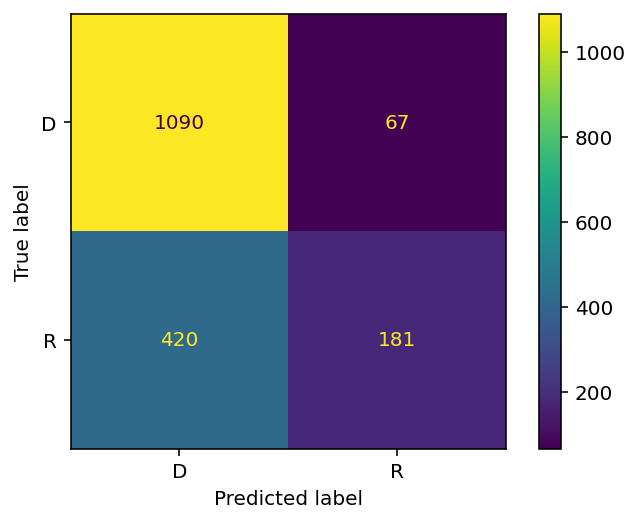

In [19]:
plot_confusion_matrix(final, X_test_fin, y_test_fin)